# Module 1. EDA and Data Split
---

본 모듈에서는 EDA(Exploratory Data Analysis; 탐색적 데이터 분석)을 통해 데이터를 간단하게 살펴 보겠습니다.

In [4]:
# !pip install joblib pyarrow

In [5]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob2
import joblib

import pyarrow
import pyarrow.parquet as pq
from pyarrow.parquet import ParquetFile

import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont

WIDTH = 236
HEIGHT = 137

<br>

## 1. Prepraing Dataset
---
### Download dataset


#### Option 1. Download using Kaggle API
Kaggle API를 통해 데이터셋을 다운로드받은 후, 압축을 해제합니다. 코드 셀 수행을 위해서 Kaggle에 가입하여 `kaggle.json`을 다운로드받으셔야 합니다.

In [6]:
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 /home/ec2-user/.kaggle/kaggle.json
# raw_data_dir = "input/raw"
# !kaggle competitions download -c bengaliai-cv19 -p {raw_data_dir}
# !unzip {raw_data_dir}/bengaliai-cv19.zip -d ./input

In [7]:
# raw_data_dir = "input/raw"
# !kaggle competitions download -c bengaliai-cv19 -p {raw_data_dir}
# !unzip {raw_data_dir}/bengaliai-cv19.zip -d ./input

#### Option 2. Download from Amazon S3
Amazon S3에 저장된 데이터셋을 다운로드합니다.

In [8]:
data_dir = './input'
#!rm -rf $data_dir
#!aws s3 cp --recursive s3://daekeun-workshop-public-material/bangali-handwritten/inputs $data_dir

In [9]:
files_train = sorted(glob2.glob(f'{data_dir}/train_*.parquet')); files_train

['./input/train_image_data_0.parquet',
 './input/train_image_data_1.parquet',
 './input/train_image_data_2.parquet',
 './input/train_image_data_3.parquet']

### Read parquet files

In [10]:
import gc
import time, sys
from timeit import timeit
from time import sleep

def read_parquet_via_pyarrow_file(filenames):
    pqfiles = [ ParquetFile(filename) for filename in filenames ]
    #print( "sys.getsizeof", humanize.naturalsize(sys.getsizeof(pqfiles)) )
    for pqfile in pqfiles[0:1]: print(pqfile.metadata)
    return pqfiles

gc.collect(); sleep(2);  # wait for gc to complete
time_start = time.time()
pqfiles = read_parquet_via_pyarrow_file(files_train); gc.collect()
print( "time: ", time.time() - time_start )
pass

  created_by: parquet-cpp version 1.4.1-SNAPSHOT
  num_columns: 32334
  num_rows: 50210
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 6089354
time:  1.0710155963897705


훈련 데이터셋은 모두 4개의 parquet 파일로 구성되어 있고, 각 parquet 파일은 32,333개의 컬럼으로 구성된 5만여 장의 이미지 데이터가 포함되어 있습니다.
- $32,333 = 1+(137 \times 236)$, 첫번째 컬럼은 Train Index로 이를 통해 정답 레이블을 알 수 있습니다.
- $137$: Height, $236$: Width

In [11]:
train_img0 = pd.read_parquet(files_train[0])
print(train_img0.shape)

(50210, 32333)


In [12]:
train_img0.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


<br>

## 2. EDA (Exploratory Data Analysis)
---

### Check raw images

실제 raw 이미지 데이터를 확인해 봅니다. 아래 셀을 여러 번 반복해서 실행해 보세요.

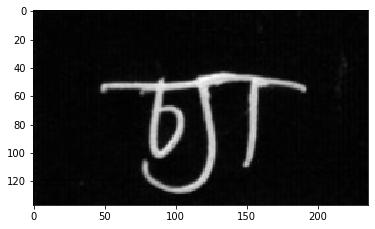

In [13]:
num_train = len(train_img0)
idx = np.random.randint(num_train)
raw_img = train_img0.iloc[idx, 1:].values.astype(np.uint8)
plt.imshow(255 - raw_img.reshape(HEIGHT, WIDTH), cmap='gray')

In [14]:
train_df = pd.read_csv('./input/train.csv')
display(train_df.head())
print(f'Number of unique grapheme roots: {train_df["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df["consonant_diacritic"].nunique()}')
print(f'Number of training data: {train_df.shape}')

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7
Number of training data: (200840, 5)


In [15]:
class_map_df = pd.read_csv('./input/class_map.csv')
display(class_map_df.head())
print(f'Size of class map: {class_map_df.shape}')      

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


Size of class map: (186, 3)


### Most used top 10 Grapheme Roots in training set

In [16]:
def get_n(df, class_map_df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char, fontsize=120):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('kalpurush-2.ttf', fontsize)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)
    return image

In [17]:
top_10_roots = get_n(train_df, class_map_df, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


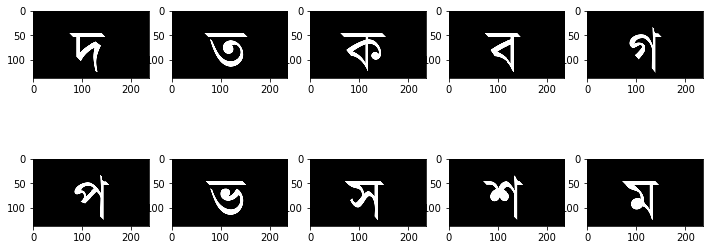

In [18]:
f, ax = plt.subplots(2, 5, figsize=(12, 5))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='gray')

### Top 5 Vowel Diacritic in taining data

In [19]:
top_5_vowels = get_n(train_df, class_map_df, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


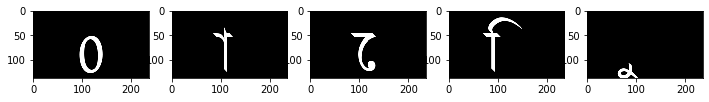

In [20]:
f, ax = plt.subplots(1, 5, figsize=(12, 3))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='gray')

### Top 5 Consonants Diacritic in taining data

In [21]:
top_5_consonants = get_n(train_df, class_map_df, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


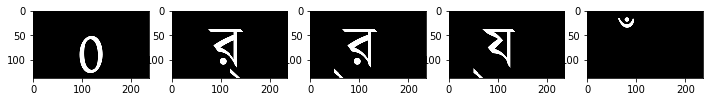

In [22]:
f, ax = plt.subplots(1, 5, figsize=(12, 3))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='gray')

### Distribution of classes

In [23]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes of selected feature; feature is a categorical value
    param: feature - the feature for which we present the distribution of classes
    param: title - title to show in the plot
    param: df - dataframe 
    param: size - size (from 1 to n), multiplied with 4 - size of plot
    '''
    f, ax = plt.subplots(1, 1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3, '{:1.2f}%'.format(100*height/total),ha="center") 
    plt.show() 

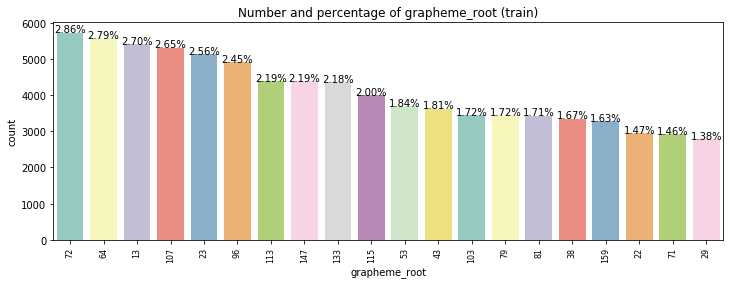

In [24]:
plot_count('grapheme_root', 'grapheme_root (train)', train_df, size=3)

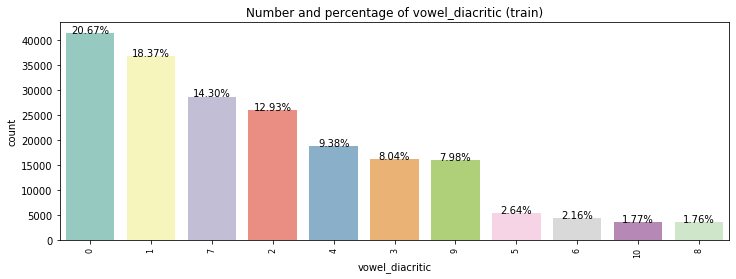

In [25]:
plot_count('vowel_diacritic', 'vowel_diacritic (train)', train_df, size=3)

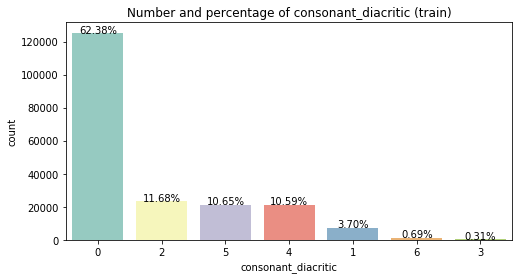

In [26]:
plot_count('consonant_diacritic', 'consonant_diacritic (train)', train_df, size=2)

<br>

## 3. Split Train/Validation Data 

1개의 레이블이 아닌 multi-label에 대한 층화추출이 필요하면 아래 라이브러리를 설치하시면 됩니다.

In [27]:
!pip install iterative-stratification

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [28]:
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

In [29]:
train_df.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id
200835,Train_200835,22,7,2,র্খে,200835
200836,Train_200836,65,9,0,ত্তো,200836
200837,Train_200837,2,1,4,অ্যা,200837
200838,Train_200838,152,9,0,স্নো,200838
200839,Train_200839,127,2,0,ল্টি,200839


In [30]:
cols = ['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
X = train_df[cols].values[:,0]
y = train_df[cols].values[:,1:]

In [31]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mask = MultilabelStratifiedKFold(n_splits=5, random_state=42)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [32]:
train_df['fold'] = -1

for i, (trn_idx, vld_idx) in enumerate(mask.split(X,y)):
    train_df.loc[vld_idx, 'fold'] = i

In [33]:
train_df['fold'].value_counts()

4    40168
3    40168
2    40168
1    40168
0    40168
Name: fold, dtype: int64

fold0 훈련 데이터셋의 클래스 분포가 전체 훈련 데이터의 분포와 동일한지 확인해 봅니다.

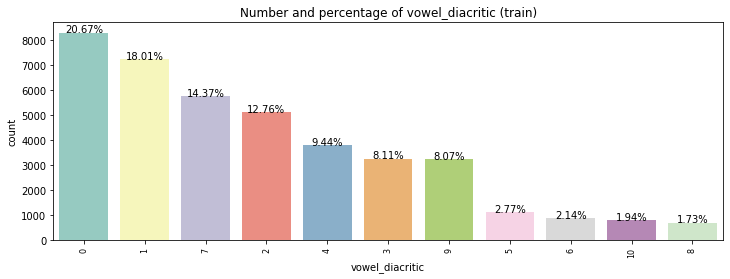

In [34]:
train_df_fold0 = train_df[train_df['fold']==0]
plot_count('vowel_diacritic', 'vowel_diacritic (train)', train_df_fold0, size=3)

fold 컬럼이 저장된 데이터프레임을 별도의 csv파일로 저장합니다. k-fold cross validation 시에, 이 csv를 재사용할 수 있습니다. 

In [35]:
train_df.to_csv(f'{data_dir}/train_folds.csv', index=False)

<br>

## 4. Copy Files to S3

아래 코드 셀은 로컬 환경에 저장되어 있는 훈련 데이터를 S3로 전송합니다. 네트워크 속도가 빠르지 않다면 수 분이 소요될 수 있습니다.
참고로, 기본 버킷은 `'sagemaker-[YOUR REGION]-[YOUT ACCOUNT ID]'` 으로 자동으로 지정되어 있고, 여러분의 고유한 S3 생성 후 이를 지정할 수도 있습니다.

In [36]:
%%time
import boto3, os
import sagemaker
bucket = sagemaker.Session().default_bucket()
prefix = 'bangali/train'
s3_bucket = boto3.Session().resource('s3').Bucket(bucket)

for file in files_train:
    f = file.split('/')[-1]
    s3_bucket.Object(os.path.join(prefix, f)).upload_file(file)
    
s3_bucket.Object(os.path.join(prefix, 'train_folds.csv')).upload_file(f'{data_dir}/train_folds.csv')

CPU times: user 1min 26s, sys: 34.1 s, total: 2min
Wall time: 48.5 s


In [37]:
s3_bucket

s3.Bucket(name='sagemaker-us-east-2-322537213286')